### Load all

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# My codes
import decoder_PC2d
import model_viz6_functions as modelviz_utils
# from model_viz6_functions import plot_samples 
#########################################

import einops
import os

import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn

jax.config.parse_flags_with_absl()
jax.config.update("jax_numpy_rank_promotion", "raise")

import matplotlib.pyplot as plt
import joblib
# import pathlib
# import pickle


import ratinabox
from ratinabox.Neurons import PlaceCells
# from ratinabox.Agent import Agent

from dsm import datasets, envs, stade #, #train #metrics, console
# from dsm import plotting, rewards 
# from dsm.state import State
# from dsm.plotting import utils as plot_utils #fig_to_ndarray

[21:43:27] INFO     MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.         ]8;id=309221;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=155660;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#88\88]8;;\

           INFO     Successfully imported OpenGL backend: glfw                                       ]8;id=27008;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=480085;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#96\96]8;;\

           INFO     MuJoCo library version is: 2.3.7                                                 ]8;id=726387;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py\__init__.py]8;;\:]8;id=153895;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py#31\31]8;;\

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/sruthi/Documents/thesis/distributional-sr/dsm/stade.py:150: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, se

### ENV and MODEL path and CONFIGs here

In [3]:
ENVIRONMENT = "Ratinabox-v0-pc-random" 
model_path = "logdir-rat_50pc_random" 

In [4]:
num_samples= 10 #config.plot_num_samples # Number of samples the model should generate

### Env and dataset

In [5]:
folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])
dataset = datasets.make_dataset(ENVIRONMENT)
# folder_dataset_path = "/media/sruthi/SSD2/sruthi_data/ratinaboxPCgoal/sac/"
# env_data_path = pathlib.Path(folder_dataset_path+"dataset.pkl")
# with env_data_path.open("rb") as fp:
#         dataset = pickle.load(fp)
# print(folder_dataset_path)
print("Dataset observations shape: ",dataset.observation.shape)
pc_path = folder_dataset_path+'/placecells_params.pkl'
log_file = folder_dataset_path+'/my_log.log'

env = envs.make(ENVIRONMENT)  #config.env
Ag = env.agent_lookup('agent_0')[0] # Agent(env) will create a new agent - agent0 already added in envs.py

PC_params = joblib.load(pc_path)
NUM_STATE_DIM_CELLS = PC_params['n']
print('NUM_STATE_DIM_CELLS:',NUM_STATE_DIM_CELLS)
PCs = PlaceCells(Ag, params=PC_params) 
# fig, ax = PCs.plot_rate_map(chosen_neurons="all")
env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
# data = datasets.make_dataset(config.env)

Dataset observations shape:  (12000, 50)
NUM_STATE_DIM_CELLS: 50


In [6]:
# env = envs.make(ENVIRONMENT) 
# dir(env)

### Input xs - create dataset of place cell activations over the whole env

In [7]:
# env_coords = Ag.Environment.flattened_discrete_coords #(10000, 2)
env_coords = Ag.Environment.discretise_environment(dx=0.01) # dx=Ag.environment.scale/10 , dx=0.01
env_coords = env_coords.reshape(-1, env_coords.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
pc_full_env = PCs.get_state(evaluate_at=None, pos=env_coords).T
pc_full_env.shape

(10000, 50)

### Decode position from PC activity

In [8]:
# dataset_positions = decoder_PC2d.simple_decode_position(dataset.observation,env_coords,pc_full_env,plot=True)
# # WORKS only when dx=0.01 in Ag.Environment.discretise_environment(dx=0.01) ?
# print(dataset_positions.shape)

/home/sruthi/Documents/thesis/distributional-sr/decoder_PC2d.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


positions_std [[0.07383863 0.03091194]
 [0.04696027 0.06615003]
 [0.0480525  0.07657142]
 ...
 [0.04243823 0.02991036]
 [0.04082555 0.02672204]
 [0.03073405 0.03567173]]


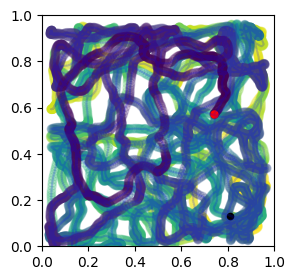

In [9]:
decoder_PC2d.train_xy_Net(PCs, Ag,epochs=50)
positions_all = decoder_PC2d.decode_position(PCs,dataset.observation,plot=True,method='dropoutNet')
positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,dataset.observation, method='dropoutNet',return_std=True)
print('positions_std',positions_std)

### Model stuff - restoring checkpoint

In [10]:
config, checkpoint_manager = modelviz_utils.load_checkpointmgr_and_config_from_path(model_path, env)
# checkpoint_manager.all_steps() # returns list of step numbers [5000, 25000, ...]
# checkpoint_manager._checkpoints[1].step 

# state, config = modelviz_utils.load_model_state_and_config_from_checkpoint_dir(model_path, env)
# print('Saved model state: Generator params shapes:',jax.tree_map(jnp.shape, state.generator.params))

# num_state_dims is the expected number of input place cells
# print(state.generator.apply_fn)  # MLP (num_layers = 3, num_hidden_units = 32, num_atoms = 10, num_state_dims = 50) #latent_dims = 5
# # print(state.generator.params['params']['model'].keys())   #  dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])
# # print(state.generator.params['params']['model']['Dense_3']['bias'].shape)  #n_outer, num_state_dims  

[21:43:57] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=538900;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=304753;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

[21:43:58] INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered     ]8;id=207161;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=821110;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    platform with name: "rocm". Available platform names are: CUDA                                 

           INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so:       ]8;id=761491;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=911204;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    libtpu.so: cannot open shared object file: No such file or directory                           

deleted  workdir


### Source states (100,50)

In [11]:
# source states to feed to the model
env_coords_small = Ag.Environment.discretise_environment(dx=0.05) # dx=Ag.environment.scale/10
# dx=0.05 , (400, 2)
#dx = 0.2, (25,2)
env_coords_small = env_coords_small.reshape(-1, env_coords.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
source_states_env = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
print(source_states_env.shape)
# plt.plot(env_coords_small[:,0],env_coords_small[:,1],'o')
# plt.ylim(0, 1)
# plt.xlim(0, 1)

unique_xpos, indices = np.unique(env_coords_small[:, 0], return_index=True)
xpos = unique_xpos[np.argsort(indices)]
unique_ypos, indices = np.unique(env_coords_small[:, 1], return_index=True)
ypos = unique_ypos[np.argsort(indices)]

# positions_all = decoder_PC2d.decode_position(PCs,source_states_env,plot=True)
# source_states_env_PCactivities = decoder_PC2d.simple_decode_position(source_states_env, env_coords, pc_full_env,plot=False)


######################################
true_PC_fullenv = PCs.get_state(evaluate_at= None, pos = env_coords_small ) # evaluate_at= "all"
true_PC_fullenv.shape

# neuron0_rate_map = true_PC_fullenv[0,:].reshape(Ag.Environment.discrete_coords.shape[:2]
#                         )
# neuron0_rate_map.shape # (100,100)
# # modelviz_utils.plot_neuron_activations(source_states_env,0,'true rate map of PC 1',xpos,ypos)
# # modelviz_utils.plot_neuron_activations(true_PC_fullenv.T,0,'true rate map of PC 1',xpos,ypos)
# # PCs.plot_rate_map(chosen_neurons='1')

(400, 50)


(50, 400)

## Show plots across checkpoints 
- how model learns 
- euclidean similarity across 20 checkpoints for 10 atoms - 50 PCs (Dense3 activations? or outputs basically- no need of internals) 

1. Choose random sources - plot (also checks if any decoded positions fall outside the bounds of env - those atoms may not be trained well?)
2. Choose atom 0 - (or atom with least max SD with final checkpoint)
- load 20 models and generate the 50 rate maps ? with same latent

- effect of different latents ?? change jax.random.PRNGKey(0) in modelviz_utils.compute_DSM_samples_single_source
- different atoms outputs as compared to original ratemaps ? ( some atoms give high SD for decoding location for different sources)

- model internals 
- plot by direction of travel - rayleigh vector


atom_input = latent+source_state

DSM model input (n_samples, n_atoms, atom_input)

### compute DSM samples

In [12]:
checkpoint_manager.all_steps()


[25000,
 50000,
 75000,
 100000,
 125000,
 150000,
 175000,
 200000,
 225000,
 250000,
 275000,
 300000,
 325000,
 350000,
 375000,
 400000,
 425000,
 450000,
 475000,
 500000]

#### comparing first and last checkpoint with same source and latent

In [13]:
# check if any atoms have high uncertainty with random sources - WITH FINAL CHECKPOINT
state_final, config = modelviz_utils.load_model_state_and_config_from_checkpoint_dir(model_path, env)
state_0, config = modelviz_utils.load_model_state_and_config_from_checkpoint_dir(model_path, env,checkpoint_step = checkpoint_manager.all_steps()[0])

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=686248;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=531412;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


debug latest_step 500000


[21:44:04] INFO     Restoring item from                                                         ]8;id=758956;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=315431;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/5000                    
                    00.                                                                                            

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1464: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


[21:44:05] INFO     Finished restoring checkpoint from                                          ]8;id=491115;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=185171;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/5000                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=193664;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=283021;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=78433;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=447674;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2500                    
                    0.                                                                                             

           INFO     Finished restoring checkpoint from                                          ]8;id=959123;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=265476;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2500                    
                    0.                                                                                             

In [14]:
random_sources = np.random.randint(0,source_states_env.shape[0],size=5)
latent_rng = jax.random.PRNGKey(0)

source pos:  [0.325 0.875]


debugging generated zs :  -2.5862386 3.8087635
Max SD of samples decoded with dropoutNet: (0.10409979, 0.108492695) ; Atom 2
Max SD of samples decoded with dropoutNet: (0.14102596, 0.28657398) ; Atom 3
Max SD of samples decoded with dropoutNet: (0.10351889, 0.19362196) ; Atom 8
decoded source:  [0.3223221 0.8464415]


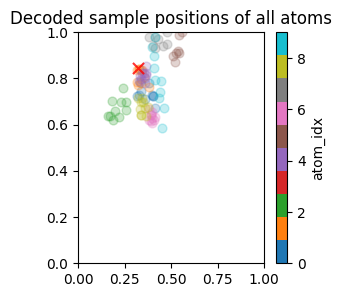

source pos:  [0.175 0.575]
debugging generated zs :  -2.5862386 3.8087635
Max SD of samples decoded with dropoutNet: (0.10014269, 0.10500514) ; Atom 7
decoded source:  [0.19876125 0.5330055 ]


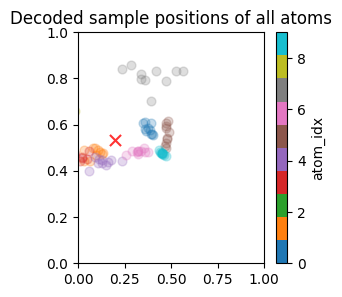

source pos:  [0.025 0.875]
debugging generated zs :  -2.5862386 3.8087635
Max SD of samples decoded with dropoutNet: (0.20326291, 0.20436905) ; Atom 3
Max SD of samples decoded with dropoutNet: (0.12079566, 0.14093772) ; Atom 4
Max SD of samples decoded with dropoutNet: (0.124493025, 0.13303883) ; Atom 8
decoded source:  [0.05369651 0.8542869 ]


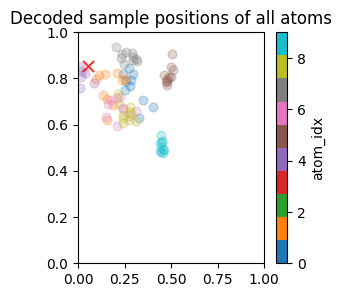

source pos:  [0.375 0.125]
debugging generated zs :  -2.5862386 3.8087635
decoded source:  [0.3841678  0.11225885]


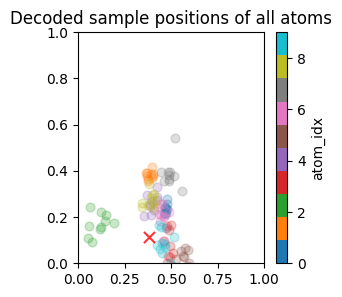

source pos:  [0.525 0.625]
debugging generated zs :  -2.5862386 3.8087635
Max SD of samples decoded with dropoutNet: (0.14582808, 0.11556698) ; Atom 8
decoded source:  [0.53483504 0.58674896]


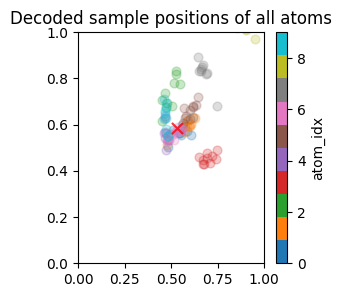

In [15]:
# FIRST CHECKPOINT
for source_idx in random_sources:
    source=source_states_env[source_idx]
    print('source pos: ',env_coords_small[source_idx])
    source, samples = modelviz_utils.compute_DSM_samples_single_source(
            state_0.generator, latent_rng, config=config, source_state_current=source, num_samples = num_samples
        )
    modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')
    

source pos:  [0.325 0.875]
debugging generated zs :  -2.5862386 3.8087635
Max SD of samples decoded with dropoutNet: (0.15691628, 0.1312198) ; Atom 6
Max SD of samples decoded with dropoutNet: (0.13511729, 0.21065167) ; Atom 8
Max SD of samples decoded with dropoutNet: (0.1612751, 0.11318368) ; Atom 9
decoded source:  [0.3223221 0.8464415]


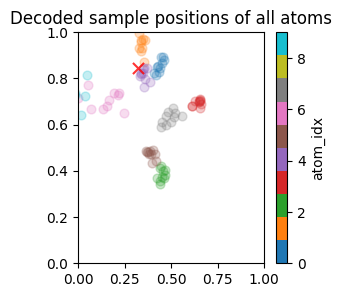

source pos:  [0.175 0.575]
debugging generated zs :  -2.5862386 3.8087635
Max SD of samples decoded with dropoutNet: (0.11284435, 0.15875272) ; Atom 8
Max SD of samples decoded with dropoutNet: (0.17570895, 0.107261404) ; Atom 9
decoded source:  [0.19876125 0.5330055 ]


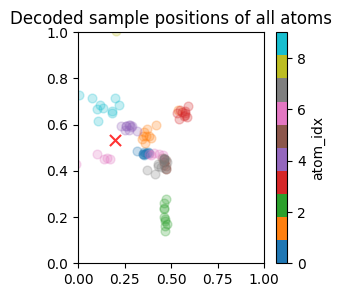

source pos:  [0.025 0.875]
debugging generated zs :  -2.5862386 3.8087635
Max SD of samples decoded with dropoutNet: (0.13507186, 0.12306961) ; Atom 3
Max SD of samples decoded with dropoutNet: (0.13297433, 0.11932873) ; Atom 4
Max SD of samples decoded with dropoutNet: (0.25893453, 0.16011494) ; Atom 6
Max SD of samples decoded with dropoutNet: (0.122014806, 0.15918201) ; Atom 8
decoded source:  [0.05369651 0.8542869 ]


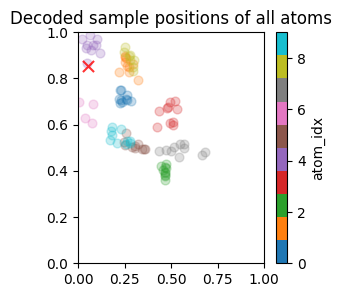

source pos:  [0.375 0.125]
debugging generated zs :  -2.5862386 3.8087635
Max SD of samples decoded with dropoutNet: (0.49172124, 0.26175007) ; Atom 2
Max SD of samples decoded with dropoutNet: (0.11340098, 0.13693638) ; Atom 4
decoded source:  [0.3841678  0.11225885]


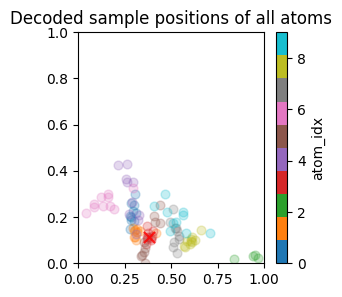

source pos:  [0.525 0.625]
debugging generated zs :  -2.5862386 3.8087635
Max SD of samples decoded with dropoutNet: (0.30183002, 0.17184569) ; Atom 2
decoded source:  [0.53483504 0.58674896]


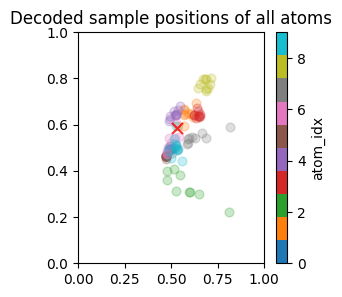

Max SD of decoded samples of atom 2 with dropoutNet: (0.3322382, 0.16175877)


In [16]:
# FINAL CHECKPOINT
for source_idx in random_sources:
    source=source_states_env[source_idx]
    print('source pos: ',env_coords_small[source_idx])
    source, samples = modelviz_utils.compute_DSM_samples_single_source(
            state_final.generator, latent_rng, config=config, source_state_current=source, num_samples = num_samples
        )
    modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')

atom_idx_values = np.arange(10) #[3,4,8]
for atom_idx in atom_idx_values:
    positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method='dropoutNet',return_std=True)
    maxc1, maxc2 = np.max(positions_std[:, 0]), np.max(positions_std[:, 1])
    if maxc1 > 0.1 and maxc2 > 0.1:
        print(f'Max SD of decoded samples of atom {atom_idx} with dropoutNet: {maxc1, maxc2}')
        
# atom_idx = 2
# positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method='dropoutNet',return_std=True)
# print(f'SD of decoded samples with dropoutNet:{positions_std}')

#### ALL CKPTS - load

In [17]:
model_states_all = []
num_ckpts = len(checkpoint_manager.all_steps()) 
for ckpt_idx in range(num_ckpts):
    state_current, config = modelviz_utils.load_model_state_and_config_from_checkpoint_dir(model_path, env,
                                                                checkpoint_step = checkpoint_manager.all_steps()[ckpt_idx])
    model_states_all.append(state_current)

[21:44:10] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=366486;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=547368;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


[21:44:11] INFO     Restoring item from                                                         ]8;id=297498;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=793505;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2500                    
                    0.                                                                                             

           INFO     Finished restoring checkpoint from                                          ]8;id=73151;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=484094;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2500                    
                    0.                                                                                             

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=70401;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=652098;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=888561;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=870184;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/5000                    
                    0.                                                                                             

           INFO     Finished restoring checkpoint from                                          ]8;id=46415;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=218632;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/5000                    
                    0.                                                                                             

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=54813;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=230920;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=170697;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=197733;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/7500                    
                    0.                                                                                             

[21:44:12] INFO     Finished restoring checkpoint from                                          ]8;id=267520;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=249282;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/7500                    
                    0.                                                                                             

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=164372;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=297862;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=392460;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=663705;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/1000                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=751816;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=638924;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/1000                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=564486;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=984843;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=651786;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=668819;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/1250                    
                    00.                                                                                            

[21:44:13] INFO     Finished restoring checkpoint from                                          ]8;id=62776;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=555281;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/1250                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=655613;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=600428;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=889094;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=895237;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/1500                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=935760;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=723562;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/1500                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=703370;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=483297;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=135846;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=996106;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/1750                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=467586;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=518714;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/1750                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=234168;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=326540;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


[21:44:14] INFO     Restoring item from                                                         ]8;id=298915;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=26749;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2000                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=241941;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=211602;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2000                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=614592;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=622046;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=705041;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=264384;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2250                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=778155;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=604337;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2250                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=769865;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=662093;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=419182;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=593778;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2500                    
                    00.                                                                                            

[21:44:15] INFO     Finished restoring checkpoint from                                          ]8;id=76420;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=334055;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2500                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=178917;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=622574;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=539507;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=751987;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2750                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=511517;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=614297;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/2750                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=555882;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=372080;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=308183;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=239876;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/3000                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=492424;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=474054;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/3000                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=201968;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=271002;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


[21:44:16] INFO     Restoring item from                                                         ]8;id=506912;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=154989;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/3250                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=213301;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=986966;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/3250                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=142191;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=904861;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=127670;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=619102;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/3500                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=650971;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=60591;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/3500                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=791916;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=293987;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


[21:44:17] INFO     Restoring item from                                                         ]8;id=596960;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=902807;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/3750                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=345580;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=241708;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/3750                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=640831;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=497379;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=919080;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=997623;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/4000                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=227941;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=964627;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/4000                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=669058;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=686689;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=828933;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=561415;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/4250                    
                    00.                                                                                            

[21:44:18] INFO     Finished restoring checkpoint from                                          ]8;id=508832;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=908235;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/4250                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=332122;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=524488;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=949576;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=122238;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/4500                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=652317;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=199831;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/4500                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=467936;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=923585;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=705154;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=906024;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/4750                    
                    00.                                                                                            

[21:44:19] INFO     Finished restoring checkpoint from                                          ]8;id=678841;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=584819;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/4750                    
                    00.                                                                                            

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=397524;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=376650;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=470482;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=26814;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/5000                    
                    00.                                                                                            

           INFO     Finished restoring checkpoint from                                          ]8;id=845186;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=29457;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir-rat_50pc_random/5000                    
                    00.                                                                                            

#### for ALL CKPTS: choose 1 atom (/10) and 1 latent
- but different atoms?
- different latents for same atom?

In [18]:
# (env divided into 100 xy positions: INPUT DIM (55) - PC activity dim 50 + fixed LATENT STATE(dim 5)

#TODO - select atom
atom_num = 4  # ith atom
print('Atom: ',atom_num)
rng_seed = 0 # FIXED LATENT STATE SEED
zs = jax.random.normal(jax.random.PRNGKey(rng_seed), (config.latent_dims,))
print('zs ',zs)

Atom:  4
zs  [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


#### Dense 3 activations correspond to output - should look like place cell ratemaps 

In [19]:
print(f' Input sources: {source_states_env.shape[0]}, PCs: {source_states_env.shape[1]}')

 Input sources: 400, PCs: 50


In [20]:
#TODO - select layer
layers = ['Dense_3',]
# Plot intermediate activations as 2D maps

activations_layer_1atom_allckpts = [] # of length num_ckpts
for i,state_current in enumerate(model_states_all):
    print(f'Checkpoint:{i+1}/{num_ckpts} - Step: {checkpoint_manager.all_steps()[i]} - Atom: {atom_num} - layer: {layers}')
    model_generator = state_current.generator
    atom_params = modelviz_utils.extract_params_ith_atom(model_generator, atom_num, config.num_outer )

    activations_layer = modelviz_utils.compute_activation_layer_all_sources(model_generator, atom_params, source_states_env,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(100,50) for Dense_3
    activations_layer_1atom_allckpts.append(activations_layer)

Checkpoint:1/20 - Step: 25000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:2/20 - Step: 50000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:3/20 - Step: 75000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:4/20 - Step: 100000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:5/20 - Step: 125000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:6/20 - Step: 150000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:7/20 - Step: 175000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:8/20 - Step: 200000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:9/20 - Step: 225000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:10/20 - Step: 250000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:11/20 - Step: 275000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:12/20 - Step: 300000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:13/20 - Step: 325000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:14/20 - Step: 350000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:15/20 - Step: 375000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:16/20 - Step: 400000 - Atom: 4 - layer: ['Dense_3']
Chec

In [21]:
# import importlib
# importlib.reload(modelviz_utils)

Atom: 4 - Layer: ['Dense_3'] - Neuron: 0


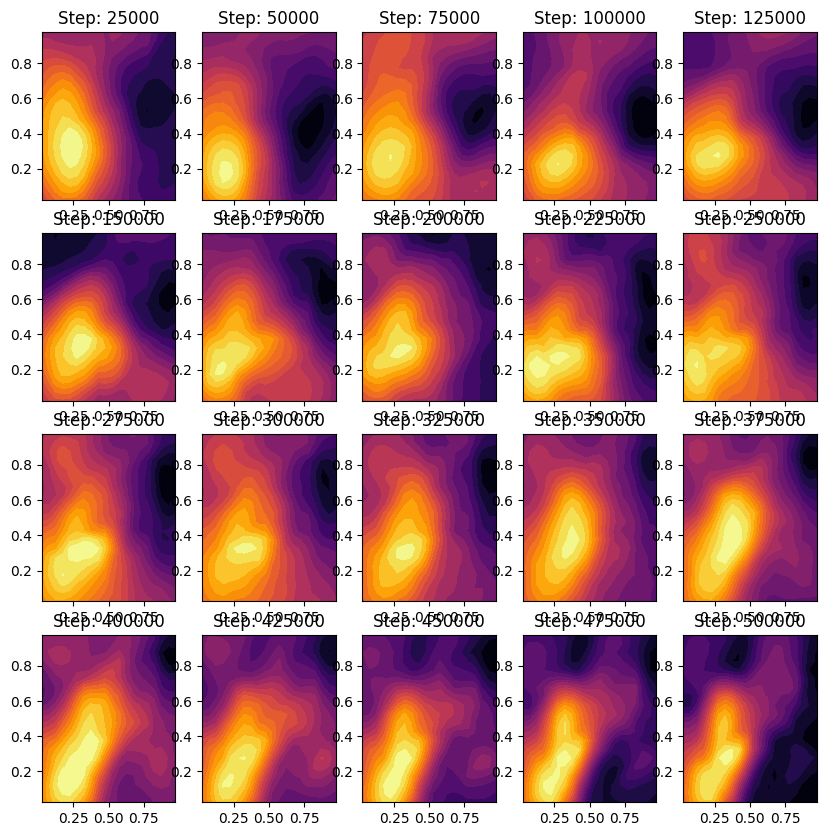

In [22]:
neuron_idx=0 # neuron_idx = 'all' or some int in range(0,9) 
print(f'Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}')

# Determine the number of rows and columns for the subplots
n = len(activations_layer_1atom_allckpts)
cols = 5
rows = n // cols
rows += n % cols
position = range(1,n + 1)
# Create the subplots
fig = plt.figure(figsize=(10, 10))

for k, activations_layer in enumerate(activations_layer_1atom_allckpts): 
    ax = fig.add_subplot(rows, cols, position[k])
    figlabel = f'Step: {checkpoint_manager.all_steps()[k]}'
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,figlabel,xpos,ypos, ax_main=ax)

# Display the plot
plt.show()


# neuron_idx=0 # neuron_idx = 'all' or some int in range(0,9) 
# print('Plotting neuron:',neuron_idx)
# for i,activations_layer in enumerate(activations_layer_1atom_allckpts[:3]): 
#     figlabel = f'Step: {checkpoint_manager.all_steps()[i]} - Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}'
#     modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,figlabel,xpos,ypos)

Plotting neuron: 0


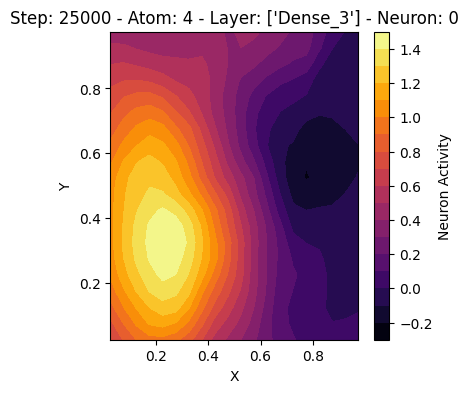

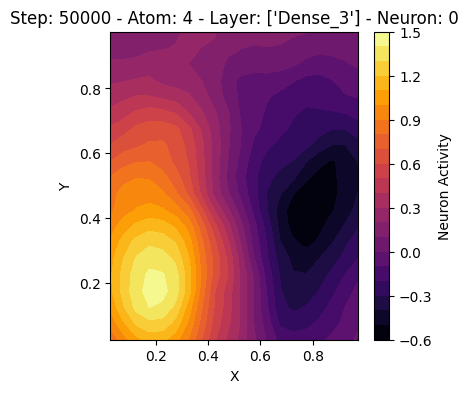

In [23]:
# just to see scale of activations
neuron_idx=0 # neuron_idx = 'all' or some int in range(0,9) 
print('Plotting neuron:',neuron_idx)
for i,activations_layer in enumerate(activations_layer_1atom_allckpts[:2]): 
    figlabel = f'Step: {checkpoint_manager.all_steps()[i]} - Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}'
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,figlabel,xpos,ypos)


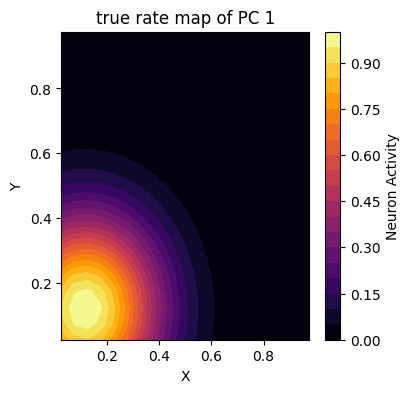

(<Figure size 250x250 with 2 Axes>, array([<Axes: >], dtype=object))

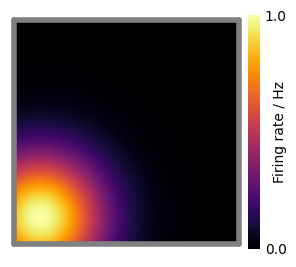

In [34]:
# modelviz_utils.plot_neuron_activations(source_states_env,0,'true rate map of PC 1',xpos,ypos)
modelviz_utils.plot_neuron_activations(true_PC_fullenv.T,0,'true rate map of PC 1',xpos,ypos)
PCs.plot_rate_map(chosen_neurons='1')


#### Euclidean similarity for PC rate maps across ckpts

In [25]:
print('Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}')
neuron_list = [0] #np.arange(activations_neuron.shape[-1])
ckpt_step_nums = checkpoint_manager.all_steps()

# from each ckpt to true rate map
modelviz_utils.compute_distance_similarity_with_trueratemap( true_PC_fullenv, activations_layer_1atom_allckpts,
                                                            ckpt_step_nums,neuron_list,metric='euclidean')
modelviz_utils.compute_distance_similarity_with_trueratemap( true_PC_fullenv, activations_layer_1atom_allckpts,
                                                            ckpt_step_nums,neuron_list,metric='cosine')
# from one ckpt to next
# modelviz_utils.compute_distance_similarity(activations_layer_1atom_allckpts, ckpt_step_nums, neuron_list, metric='euclidean')
# modelviz_utils.compute_distance_similarity(activations_layer_1atom_allckpts, ckpt_step_nums, neuron_list, metric='cosine')

Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}
Neuron:  0
Ckpt Step: 25000: euclidean score: 10.528476776885155
Ckpt Step: 50000: euclidean score: 7.570745319922357
Ckpt Step: 75000: euclidean score: 8.13064606948481
Ckpt Step: 100000: euclidean score: 7.9464695334179725
Ckpt Step: 125000: euclidean score: 8.096362892352998
Ckpt Step: 150000: euclidean score: 8.211314522068706
Ckpt Step: 175000: euclidean score: 5.725982830551842
Ckpt Step: 200000: euclidean score: 7.795704074067619
Ckpt Step: 225000: euclidean score: 5.138323681774117
Ckpt Step: 250000: euclidean score: 4.380231145639723
Ckpt Step: 275000: euclidean score: 5.289960134405036
Ckpt Step: 300000: euclidean score: 5.6226774141437375
Ckpt Step: 325000: euclidean score: 6.255237561795419
Ckpt Step: 350000: euclidean score: 7.369391686926988
Ckpt Step: 375000: euclidean score: 7.018279556046885
Ckpt Step: 400000: euclidean score: 5.823990750336163
Ckpt Step: 425000: euclidean score: 6.139405398104286
Ckpt Step: 450

In [35]:
print('Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}')
neuron_list = [0] #np.arange(activations_neuron.shape[-1])
ckpt_step_nums = checkpoint_manager.all_steps()

normalized_activations_layer_1atom_allckpts = []
for activations in activations_layer_1atom_allckpts:
    min_val = np.amin(activations, axis=0)
    max_val = np.amax(activations, axis=0)
    activations_normalized = (activations - min_val) / (max_val - min_val)
    normalized_activations_layer_1atom_allckpts.append(activations_normalized)

# from each ckpt to true rate map
modelviz_utils.compute_distance_similarity_with_trueratemap( true_PC_fullenv, normalized_activations_layer_1atom_allckpts,
                                                            ckpt_step_nums,neuron_list,metric='euclidean')
modelviz_utils.compute_distance_similarity_with_trueratemap( true_PC_fullenv, normalized_activations_layer_1atom_allckpts,
                                                            ckpt_step_nums,neuron_list,metric='cosine')
# modelviz_utils.compute_distance_similarity(activations_layer_1atom_allckpts,ckpt_step_nums,neuron_list,metric='euclidean')
# modelviz_utils.compute_distance_similarity(activations_layer_1atom_allckpts,ckpt_step_nums,neuron_list,metric='cosine')


Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}
Neuron:  0
Ckpt Step: 25000: euclidean score: 7.262328652471878
Ckpt Step: 50000: euclidean score: 6.41908874209967
Ckpt Step: 75000: euclidean score: 8.706653314743722
Ckpt Step: 100000: euclidean score: 7.1029733760923355
Ckpt Step: 125000: euclidean score: 7.239579863306154
Ckpt Step: 150000: euclidean score: 7.0450873732565125
Ckpt Step: 175000: euclidean score: 7.911328359552822
Ckpt Step: 200000: euclidean score: 7.203876668260432
Ckpt Step: 225000: euclidean score: 7.021211564925447
Ckpt Step: 250000: euclidean score: 8.21017068855472
Ckpt Step: 275000: euclidean score: 8.179548197161205
Ckpt Step: 300000: euclidean score: 8.46578932580103
Ckpt Step: 325000: euclidean score: 8.12779828215148
Ckpt Step: 350000: euclidean score: 8.194108079520836
Ckpt Step: 375000: euclidean score: 8.386588295483236
Ckpt Step: 400000: euclidean score: 8.251412139720104
Ckpt Step: 425000: euclidean score: 7.40722991445664
Ckpt Step: 450000: 

Plotting neuron: 0


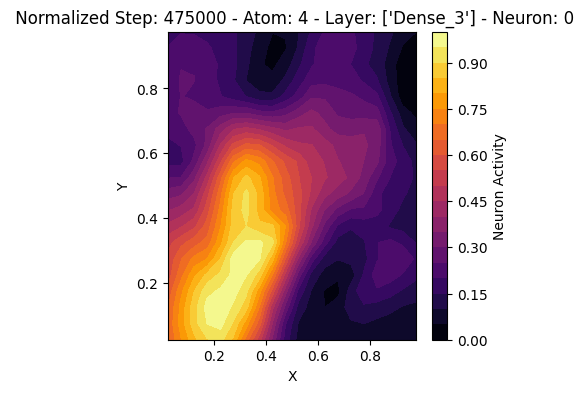

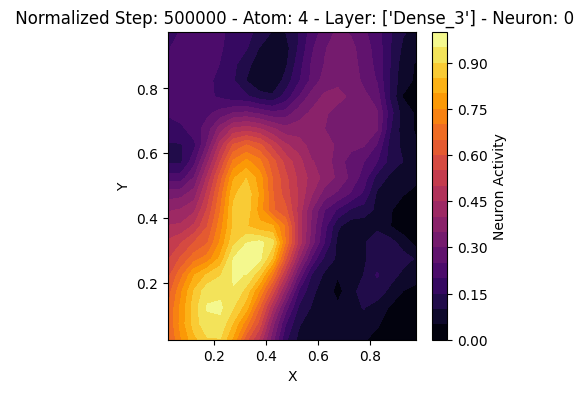

: 

In [36]:
neuron_idx=0 # neuron_idx = 'all' or some int in range(0,9) 
print('Plotting neuron:',neuron_idx)
for i,activations_layer in enumerate(normalized_activations_layer_1atom_allckpts[-2:]): 
    figlabel = f' Normalized Step: {checkpoint_manager.all_steps()[-2:][i]} - Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}'
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,figlabel,xpos,ypos)


Plotting neuron: all


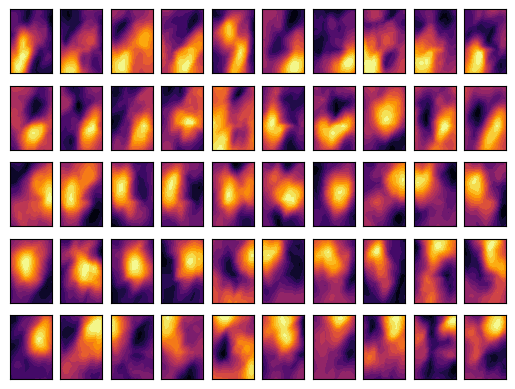

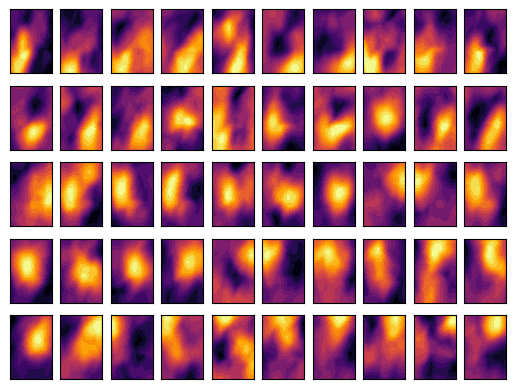

In [28]:
neuron_idx='all' # neuron_idx = 'all' or some int in range(0,9) 
print('Plotting neuron:',neuron_idx)
for i,activations_layer in enumerate(activations_layer_1atom_allckpts[-2:]):
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,layers,xpos,ypos)

In [29]:
# DIFFERENT LATENTS
# - later try all latent dim 5 having same values?
# - see which neurons dont change much with latent state ?

# activations_neurons_randomz = []
# for rng_seed in range(3):
#     zs = jax.random.normal(jax.random.PRNGKey(rng_seed), (config.latent_dims,))
#     print('zs',zs)
#     activations_neurons = modelviz_utils.compute_activation_layer_all_sources(model_generator,atom_params, source_states_env,zs, layers)
#     activations_neurons_randomz.append(activations_neurons)
# for i in range(len(activations_neurons_randomz)):
#     neuron_idx = np.arange(activations_neurons_randomz[i].shape[-1])
#     modelviz_utils.plot_neuron_activations(activations_neurons_randomz[i],neuron_idx,layers,xpos,ypos)

In [30]:
# layers = ['Dense_2',]
# layers = ['Dense_1',]
# layers = ['Dense_0',]

In [31]:
### All intermediates
# #TODO - select layer
# layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
# rng = jax.random.PRNGKey(0)
# zs = jax.random.normal(rng, (config.latent_dims,))
# # zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
# activations_alllayers = modelviz_utils.compute_activation_allintermediates_all_sources(model_generator, atom_params, source_states_env, zs, layers)
# # print(activations_alllayers['Dense_0'] )
# # joblib.dump(activations_alllayers, model_path+f'/activations_alllayers_latent_atom{atom_i}.pkl')
# # activations_alllayers = joblib.load('activations_alllayers_latent_atom{atom_i}.pkl')

### Different atom

In [32]:
# i = 4  # ith atom
# layers = ['Dense_3',]
# sel_neuron_idx=0 # neuron_idx = np.arange(activations_neurons.shape[-1])
# random_seed = 0

# atom_params = modelviz_utils.extract_params_ith_atom(state.generator, i, config.num_outer )
# zs = jax.random.normal(jax.random.PRNGKey(random_seed), (config.latent_dims,))
# activations_neurons = modelviz_utils.compute_activation_layer_all_sources(model_generator, atom_params, source_states_env,zs, layers)
# print(activations_neurons.shape)
# modelviz_utils.plot_neuron_activations(activations_neurons,neuron_idx,layers,xpos,ypos)

## Later

- decoding from hidden neuron to start and end state, 
- tsne/ umap
- entropy

Model will generate different successor states from the same source state (effect of different latents?, try giving all 5 same?). \
Different source states may generate same successor states (same x,y positions) 

xs[:,:,-3:] #same - context - source state , rest noise latent dims  \
 xs_atom #shape (8)

In [33]:
# from model_viz6_functions import show_allsamples_compute_activation_layer_all_sources, plot_neuron_activations_samples

# num_samples=7 #config.plot_num_samples # Number of state samples 
# print(f' using {num_samples} samples')
# layers = ['Dense_3',]  # # layer 3 activations are predicted states
# activations_layer = show_allsamples_compute_activation_layer_all_sources(model_generator, atom_params, source_states_env, layers,num_samples,config.latent_dims)
# print(activations_layer.shape)
# assert activations_layer.shape[-1] == 50
# neuron_idx = 2
# label=f'Activations of neuron {neuron_idx} of  {layers} all generated samples'
# plot_neuron_activations_samples(activations_layer,neuron_idx,label,xpos, ypos)

# source_idx = 10
# plt.scatter(x[source_idx], y[source_idx], marker="x", color="red")
# predicted_states = activations_layer[ source_idx,:, :]
# decode x and y position from predicted PC activations
# plt.scatter(x_pred, y_pred)